In [1]:
# %load first_cell.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns

%load_ext autoreload
%autoreload 2

# Load in Building Energy Data

In [3]:
data = pd.read_csv('/data/forecast/train_clean.csv', parse_dates = ['Timestamp'])
data = data[['Timestamp', 'Value', 'Temperature', 'off', 'SiteId']]
data.head()

Timestamp         Value  Temperature  off  SiteId
0 2009-06-23 06:45:00  96408.826731         14.0    0     297
1 2009-06-23 07:45:00  76800.251802         15.0    0     297
2 2009-06-23 08:45:00  75166.203892         16.0    0     297
3 2009-06-23 09:45:00  71898.108070         18.0    0     297
4 2009-06-23 10:45:00  73532.155981         21.0    0     297

The next cell finds the number of measurements for each building and displays those with the most measurements.

In [4]:
buildings = data.groupby('SiteId')['Value'].count().to_frame()
buildings.sort_values('Value', ascending = False).head(10)

Value
SiteId        
302     223620
261     154219
6       139716
269     126370
271     124407
237     120432
8       114962
276     102359
233     102255
235     102187

Let's select one of the buildings with the most measurements and take a look at the data.

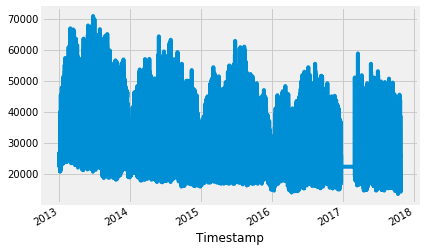

In [5]:
df = data[data['SiteId'] == 6].copy().set_index('Timestamp')

# Plot over time
df['Value'].plot()

We'll use the first four years of measurements.

In [6]:
df = df[(df.index > pd.datetime(2013, 1, 1)) & (df.index < pd.datetime(2017, 1, 1))]
df.head()

Value  Temperature  off  SiteId
Timestamp                                                  
2013-01-01 01:00:00  25108.373290          NaN    0       6
2013-01-01 01:15:00  25062.047878          NaN    0       6
2013-01-01 01:30:00  25015.722466          NaN    0       6
2013-01-01 01:45:00  24969.397055          NaN    0       6
2013-01-01 02:00:00  24923.071643          NaN    0       6

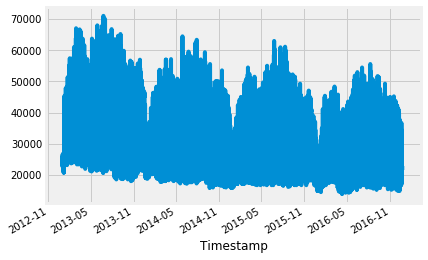

In [7]:
df['Value'].plot()

# Extract Date and Time Information

First, let's write a basic function that extract the date and time information from a timestamp.

In [8]:
import re 

def extract_datetime(df, date_col, time = False):

    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    
    # Remove the time zone if present
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    # Change the prefix for the new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]imestamp|[Tt]ime', '', pre)
    
    # Basic date attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
            
    # If time is specified, add extra columns
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
            
    return df

In [9]:
df = extract_datetime(df.reset_index(), 'Timestamp', time = True)
df.head()

Timestamp         Value  Temperature  off  SiteId  Year  Month  \
0 2013-01-01 01:00:00  25108.373290          NaN    0       6  2013      1   
1 2013-01-01 01:15:00  25062.047878          NaN    0       6  2013      1   
2 2013-01-01 01:30:00  25015.722466          NaN    0       6  2013      1   
3 2013-01-01 01:45:00  24969.397055          NaN    0       6  2013      1   
4 2013-01-01 02:00:00  24923.071643          NaN    0       6  2013      1   

   Week  Day  Dayofweek  Dayofyear  Hour  Minute  Second  
0     1    1          1          1     1       0       0  
1     1    1          1          1     1      15       0  
2     1    1          1          1     1      30       0  
3     1    1          1          1     1      45       0  
4     1    1          1          1     2       0       0

Extracting this basic information should be the first step when you get a new time-series. Once you have the information, you can start to explore the data and understand the trends. For example, the plot below shows the average electricity consumption for each time interval by day.

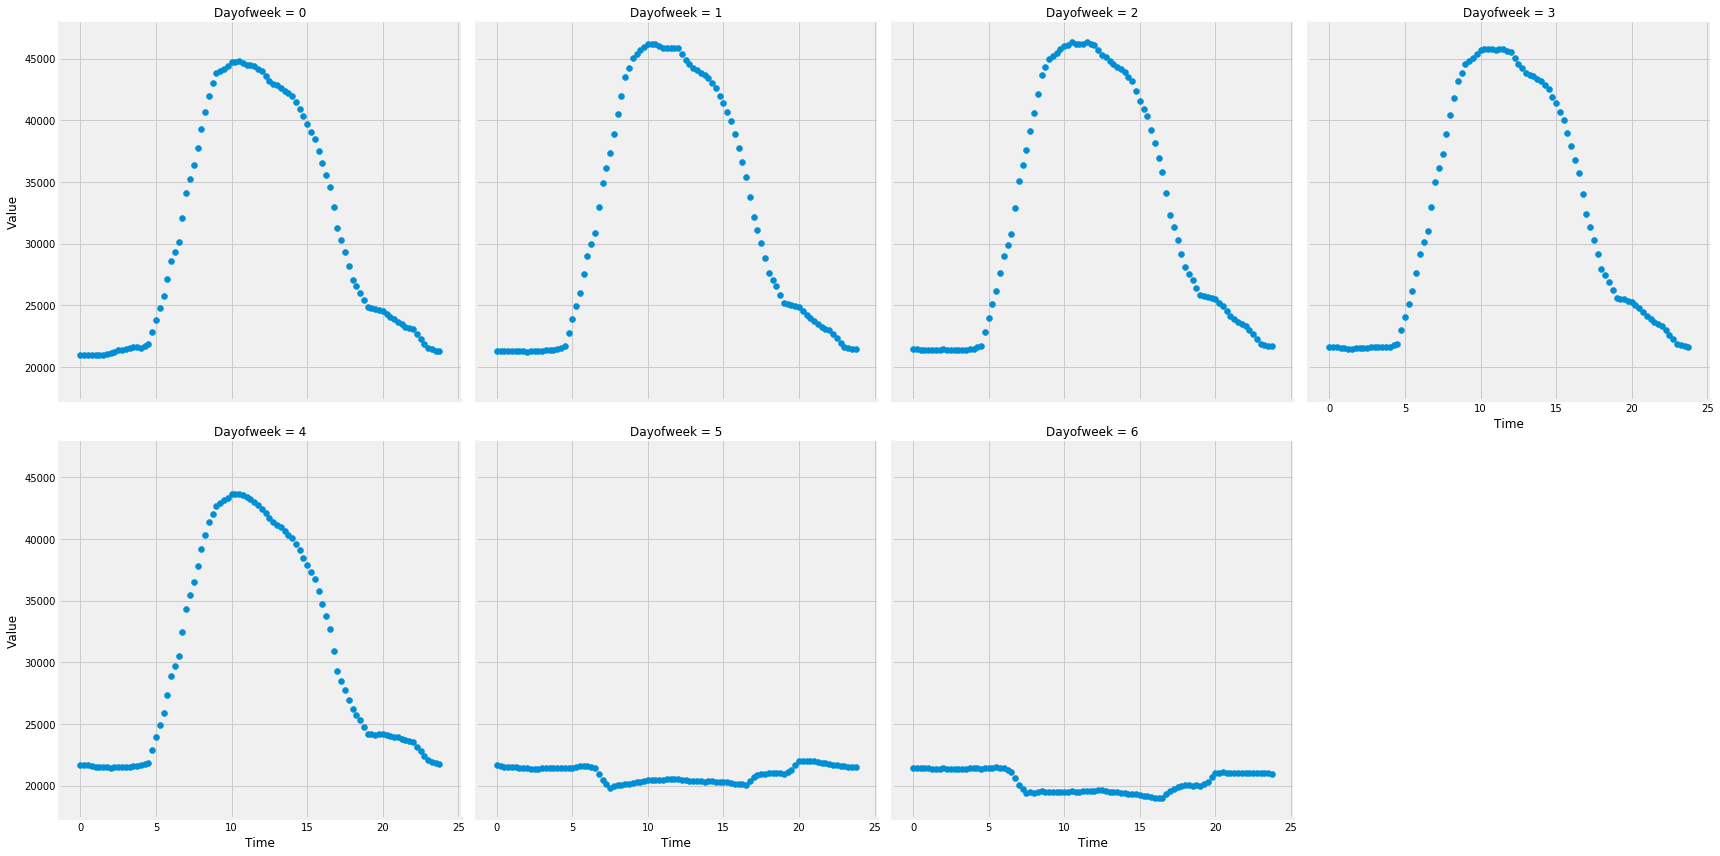

In [10]:
day_avg = df.groupby(['Dayofweek', 'Hour', 'Minute'])['Value'].mean().to_frame().reset_index()
day_avg['Time'] = day_avg['Hour'] + day_avg['Minute'] / 60

g = sns.FacetGrid(day_avg, col = 'Dayofweek', col_wrap = 4, height = 6)
g.map(plt.scatter, 'Time', 'Value');

We can clearly see the trends across the course of a day as well as over the week.

Let's start trying to model some of these relationships using the newly created features.

# Modeling

First we'll start with a simple example, using Monday, Tuesday, and Wednesday of a week to predict the energy consumption on Thursday and Friday. Let's write a quick function to extract a random week of data.

In [38]:
import random
random.seed(50)

def random_week():
   
    # List of week starts
    starts = list(df.loc[(df['Dayofweek'] == 0) & (df['Hour'] == 0) & (df['Minute'] == 0)].index)
    points = 0
    
    # Find an interval exactly one week long
    while points != (24 / 0.25) * 7:
        
        # Pick a random starting point
        start = random.sample(starts, 1)[0]

        # Find the ending point of the week
        end = start + pd.Timedelta(1, 'W') - pd.Timedelta(15, 'm')
        
        # Subset the data and check the number of observations
        week = df.loc[start:end, :].copy()
        points = week.shape[0]
        
    return week

In [40]:
# df.set_index('Timestamp', inplace = True)
week = random_week()
week.head()

Value  Temperature  off  SiteId  Year  Month  \
Timestamp                                                                  
2015-02-23 00:00:00  20568.482917         20.0    0       6  2015      2   
2015-02-23 00:15:00  20290.530445          NaN    0       6  2015      2   
2015-02-23 00:30:00  20012.577973         20.0    0       6  2015      2   
2015-02-23 00:45:00  20197.879621          NaN    0       6  2015      2   
2015-02-23 01:00:00  20383.181269         18.5    0       6  2015      2   

                     Week  Day  Dayofweek  Dayofyear  Hour  Minute  Second  
Timestamp                                                                   
2015-02-23 00:00:00     9   23          0         54     0       0       0  
2015-02-23 00:15:00     9   23          0         54     0      15       0  
2015-02-23 00:30:00     9   23          0         54     0      30       0  
2015-02-23 00:45:00     9   23          0         54     0      45       0  
2015-02-23 01:00:00     9   23          0         54     1       0       0

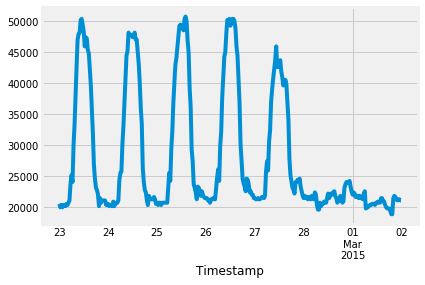

In [41]:
week['Value'].plot()

# Daily Energy Use

First we'll try to predict daily energy use with Monday, Tuesday, and Wednesday as training and Thursday and Friday as testing. (For now we won't worry about the weekend)

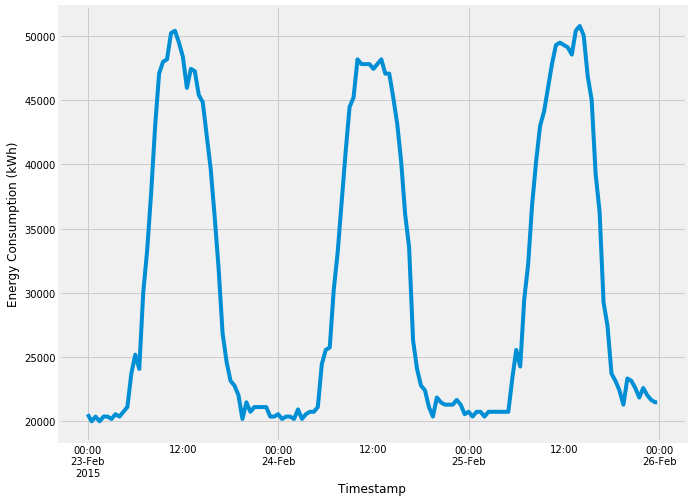

In [42]:
train = week[week['Dayofweek'].isin([0, 1, 2])].copy()
test = week[week['Dayofweek'].isin([3, 4])].copy()

train['Value'].plot(figsize = (10, 8))
plt.ylabel('Energy Consumption (kWh)');

## First Prediction Attempt: Time of Day in Hours and Minutes

Our first model will use simple features: the time of day in hours and minutes. We'll use a linear regression model.

In [43]:
from sklearn.linear_model import LinearRegression

def metrics(y_true, y_pred, set_name = 'Test'):
    """Calculate root mean squared error and 
       mean absolute percentage error."""
    
    rmse = np.sqrt(np.mean(np.square(y_true - y_pred)))
    mape = 100 * np.mean(abs((y_true - y_pred) / y_true))
    
    print(f'{set_name:5}: rmse = {round(rmse, 2)} \t mape = {round(mape, 2)}')
    
    return round(rmse, 2), round(mape, 2)

lr = LinearRegression()

In [44]:
lr.fit(train[['Hour', 'Minute']], train['Value'])

train_preds = lr.predict(train[['Hour', 'Minute']])
test_preds = lr.predict(test[['Hour', 'Minute']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 11394.46 	 mape = 35.82
Test : rmse = 10225.95 	 mape = 30.65


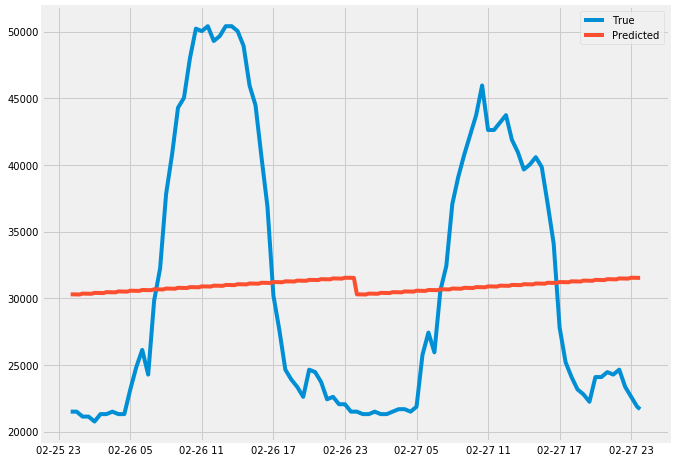

In [45]:
plt.figure(figsize = (10, 8))
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'Predicted');
plt.legend();

In [46]:
x = pd.Series([1, 2, 10 ,15])
x[x > 5]

2    10
3    15
dtype: int64

## Try Decimal Time

What happens if we try to model using the decimal time of the day in hours? In effect, we're taking two variables, `Hour` and `Minute`, and compressing them into one. 

In [47]:
week['Fractime'] = (week['Hour'] + week['Minute'] / 60).copy()

train = week.loc[week['Dayofweek'].isin([0, 1, 2])].copy()
test = week.loc[week['Dayofweek'].isin([3, 4])].copy()

lr.fit(train[['Fractime']], train['Value'])

train_preds = lr.predict(train[['Fractime']])
test_preds = lr.predict(test[['Fractime']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 11394.48 	 mape = 35.82
Test : rmse = 10226.01 	 mape = 30.65


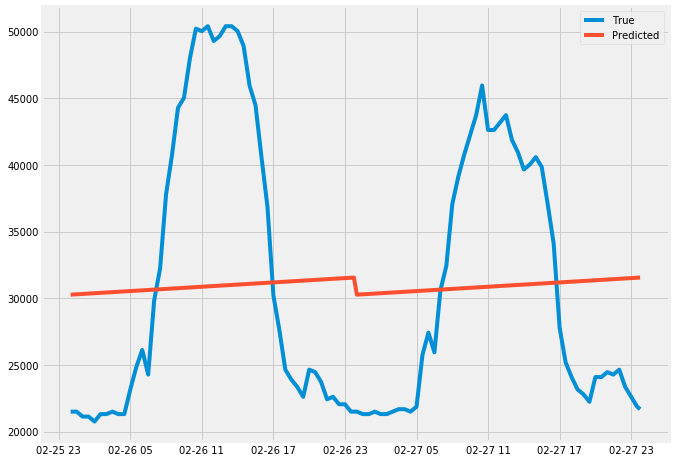

In [48]:
plt.figure(figsize = (10, 8))
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'Predicted');
plt.legend();

Still no good. We need a new solution, one that allows our model to differentiate between times. Enter cyclical variable encoding. 

# Cyclical Variable Encoding

This is an extremely simple yet powerful technique. The idea is to transform a single time series into a representation by sines and cosines. I think the best way to understand how this works is simply to do it! To encode a variable `x` in its cyclical representation, we use the following two equations:

$$\text{x-sin} = \sin{\frac{2 * \pi * x}{\text{period}}}$$

$$\text{x-cos} = \cos{\frac{2 * \pi * x}{\text{period}}}$$

Where $\text{period}$ is the amount of time needed for the variable to complete one cycle. For example, the decimal time of day has a period of 24, and the day of week has a period of 7 (actually 6 since Python uses 0-6 for the days of the week). An easy way to find the period is simply to look for the max of the cyclical variable (this becomes tricky with months).

In [49]:
week['Fractime-sin'] = np.sin((2 * np.pi * week['Fractime']) / 23.75)
week['Fractime-cos'] = np.cos((2 * np.pi * week['Fractime']) / 23.75)

What did we just do? One way to find out is by plotting.

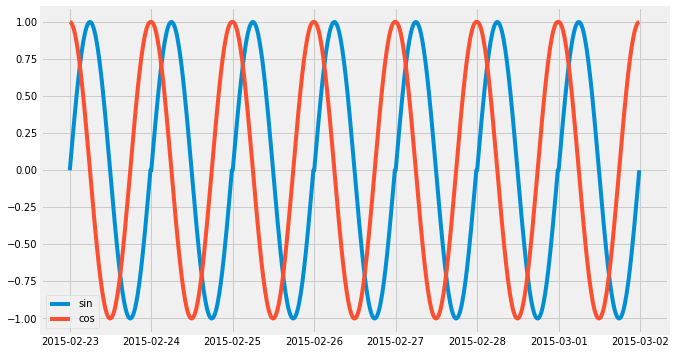

In [51]:
plt.figure(figsize = (10, 6))
plt.plot(week['Fractime-sin'], label = 'sin')
plt.plot(week['Fractime-cos'], label = 'cos')
plt.legend();

In [62]:
train = week.loc[week['Dayofweek'].isin([0, 1, 2])].copy()
test = week.loc[week['Dayofweek'].isin([3, 4])].copy()

lr.fit(train[['Fractime-sin', 'Fractime-cos']], train['Value'])

train_preds = lr.predict(train[['Fractime-sin', 'Fractime-cos']])
test_preds = lr.predict(test[['Fractime-sin', 'Fractime-cos']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 4094.78 	 mape = 13.37
Test : rmse = 4089.13 	 mape = 13.26


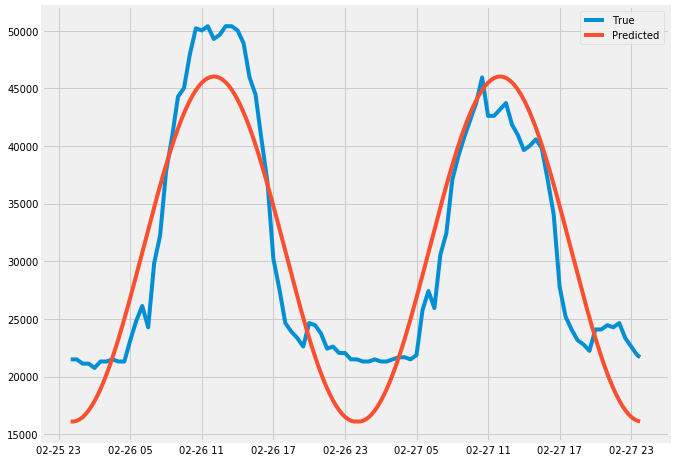

In [63]:
plt.figure(figsize = (10, 8))
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'Predicted');
plt.legend();

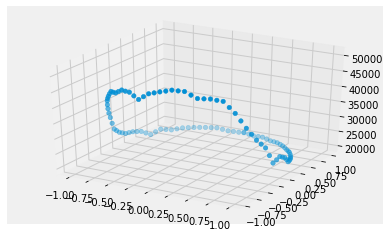

In [64]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train['Fractime-sin'][:96], train['Fractime-cos'][:96], train['Value'][:96])

While this does work for a few days, if we want to extend this to weeks, we'll have to make more cyclical variables.

In [91]:
def random_month():
   
    # List of week starts
    starts = list(df.loc[(df['Dayofweek'] == 0) & (df['Hour'] == 0) & (df['Minute'] == 0)].index)
    points = 0
    
    # Find an interval exactly one month long
    while points != (24 / 0.25) * 7 * 28:
        
        # Pick a random starting point
        start = random.sample(starts, 1)[0]

        # Find the ending point of the week
        end = start + pd.Timedelta(4, 'W') - pd.Timedelta(15, 'm')
        
        # Subset the data and check the number of observations
        week = df.loc[start:end, :].copy()
        points = week.shape[0]

    return week

In [92]:
month = random_month()

KeyboardInterrupt: 

In [72]:
averages = df.groupby(['Dayofweek', 'Hour', 'Minute'])['Value'].agg(np.nanmean).to_frame().reset_index()
averages.head()

Dayofweek  Hour  Minute         Value
0          0     0       0  20970.022749
1          0     0      15  20956.577730
2          0     0      30  20943.132711
3          0     0      45  20948.457471
4          0     1       0  20950.587375

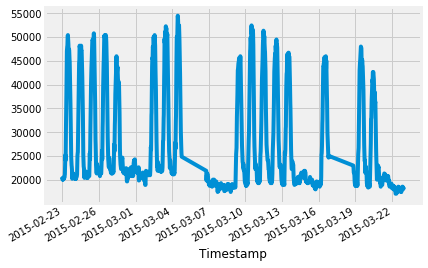

In [135]:
month = df.loc[week.index[0]: week.index[0] + pd.Timedelta(4, 'W') - pd.Timedelta(15, 'm'), :].copy()
month['Value'].plot()

In [136]:
right_index = pd.date_range(month.index[0], end = month.index[0] + pd.Timedelta(4, 'W') - pd.Timedelta(15, 'm'), 
                            periods = 96 * 28)
len(right_index)

2688

In [137]:
month = month.reindex(index = right_index)
month['Timestamp'] = month.index
month = extract_datetime(month, 'Timestamp', time = True)
month.shape

(2688, 14)

In [138]:
month.head()

Value  Temperature  off  SiteId  Year  Month  \
2015-02-23 00:00:00  20568.482917         20.0  0.0     6.0  2015      2   
2015-02-23 00:15:00  20290.530445          NaN  0.0     6.0  2015      2   
2015-02-23 00:30:00  20012.577973         20.0  0.0     6.0  2015      2   
2015-02-23 00:45:00  20197.879621          NaN  0.0     6.0  2015      2   
2015-02-23 01:00:00  20383.181269         18.5  0.0     6.0  2015      2   

                     Week  Day  Dayofweek  Dayofyear  Hour  Minute  Second  \
2015-02-23 00:00:00     9   23          0         54     0       0       0   
2015-02-23 00:15:00     9   23          0         54     0      15       0   
2015-02-23 00:30:00     9   23          0         54     0      30       0   
2015-02-23 00:45:00     9   23          0         54     0      45       0   
2015-02-23 01:00:00     9   23          0         54     1       0       0   

                              Timestamp  
2015-02-23 00:00:00 2015-02-23 00:00:00  
2015-02-23 00:15:00 2015-02-23 00:15:00  
2015-02-23 00:30:00 2015-02-23 00:30:00  
2015-02-23 00:45:00 2015-02-23 00:45:00  
2015-02-23 01:00:00 2015-02-23 01:00:00

In [139]:
month[month['Hour'].isnull()]

Empty DataFrame
Columns: [Value, Temperature, off, SiteId, Year, Month, Week, Day, Dayofweek, Dayofyear, Hour, Minute, Second, Timestamp]
Index: []

In [140]:
month = month.reset_index()
month = month.merge(averages, on = ['Dayofweek' ,'Hour', 'Minute'], how = 'outer')
month.loc[month['Value_x'].isnull(), 'Value_x'] = month.loc[month['Value_x'].isnull(), 'Value_y']
month = month.rename(columns = {'Value_x': 'Value', 'Value_y': 'Average'})
month.head()

index         Value  Temperature  off  SiteId  Year  Month  \
0 2015-02-23 00:00:00  20568.482917         20.0  0.0     6.0  2015      2   
1 2015-03-02 00:00:00  21124.387861         19.0  0.0     6.0  2015      3   
2 2015-03-09 00:00:00  18344.863142         18.0  0.0     6.0  2015      3   
3 2015-03-16 00:00:00  19086.069734         18.0  0.0     6.0  2015      3   
4 2015-02-23 00:15:00  20290.530445          NaN  0.0     6.0  2015      2   

   Week  Day  Dayofweek  Dayofyear  Hour  Minute  Second           Timestamp  \
0     9   23          0         54     0       0       0 2015-02-23 00:00:00   
1    10    2          0         61     0       0       0 2015-03-02 00:00:00   
2    11    9          0         68     0       0       0 2015-03-09 00:00:00   
3    12   16          0         75     0       0       0 2015-03-16 00:00:00   
4     9   23          0         54     0      15       0 2015-02-23 00:15:00   

        Average  
0  20970.022749  
1  20970.022749  
2  20970.022749  
3  20970.022749  
4  20956.577730

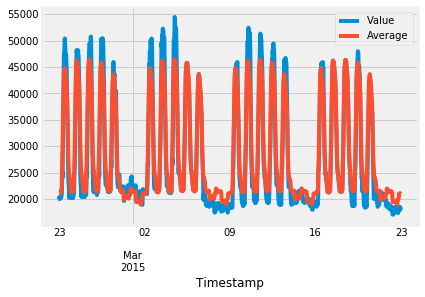

In [141]:
month = month.sort_values('index').drop(columns = 'Timestamp').rename(columns = {'index': 'Timestamp'}).set_index('Timestamp')
month[['Value', 'Average']].plot()

In [123]:
month[month['Average'].isnull()]

Value  Temperature  off  SiteId  Year  Month  Week  Day  \
Timestamp                                                                      
2015-03-04 19:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 19:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 19:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 19:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 20:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 20:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 20:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 20:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 21:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 21:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 21:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 21:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 22:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 22:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 22:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 22:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 23:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 23:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 23:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-04 23:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 00:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 00:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 00:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 00:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 01:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 01:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 01:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 01:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 02:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-05 02:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
...                    ...          ...  ...     ...   ...    ...   ...  ...   
2015-03-18 12:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 12:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 13:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 13:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 13:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 13:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 14:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 14:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 14:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 14:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 15:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 15:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 15:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 15:45:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 16:00:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 16:15:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 16:30:00    NaN          NaN  NaN     NaN   NaN    NaN   NaN  NaN   
2015-03-18 16:45:00  

In [144]:
month['time'] = month['Hour'] + month['Minute'] / 60
month['time-sin'] = np.sin((2 * np.pi * month['time']) / 23.75)
month['time-cos'] = np.cos((2 * np.pi * month['time']) / 23.75)

In [145]:
two_weeks_index = 14 * 96
train = month.iloc[:two_weeks_index]
test = month.iloc[two_weeks_index:]
train.shape[0] == test.shape[0]

True

In [146]:
lr.fit(train[['time-sin', 'time-cos']], train['Value'])

train_preds = lr.predict(train[['time-sin', 'time-cos']])
test_preds = lr.predict(test[['time-sin', 'time-cos']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 7811.41 	 mape = 22.39
Test : rmse = 7477.84 	 mape = 21.62


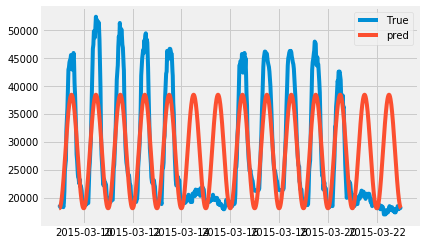

In [147]:
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'pred');
plt.legend();

In [148]:
month['Dayofweek-sin'] = np.sin((2 * np.pi * month['Dayofweek']) / 6)
month['Dayofweek-cos'] = np.cos((2 * np.pi * month['Dayofweek']) / 6)

In [149]:
two_weeks_index = 14 * 96
train = month.iloc[:two_weeks_index]
test = month.iloc[two_weeks_index:]
train.shape[0] == test.shape[0]

True

In [150]:
lr.fit(train[['time-sin', 'time-cos', 'Dayofweek']], train['Value'])
train_preds = lr.predict(train[['time-sin', 'time-cos', 'Dayofweek']])
test_preds = lr.predict(test[['time-sin', 'time-cos', 'Dayofweek']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 6531.25 	 mape = 21.28
Test : rmse = 6089.54 	 mape = 20.14


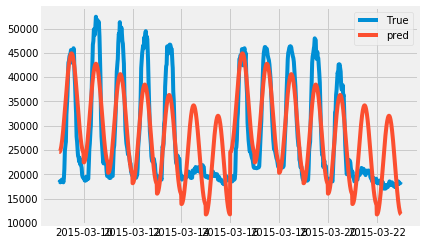

In [151]:
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'pred');
plt.legend();

In [154]:
month['Fractime-week'] = (month['Dayofweek'] * 24) + month['time']
month['Fractime-week'].describe()

count    2688.000000
mean       83.875000
std        48.506393
min         0.000000
25%        41.937500
50%        83.875000
75%       125.812500
max       167.750000
Name: Fractime-week, dtype: float64

In [152]:
lr.fit(train[['time-sin', 'time-cos', 'Dayofweek-sin', 'Dayofweek-cos']], train['Value'])
train_preds = lr.predict(train[['time-sin', 'time-cos', 'Dayofweek-sin', 'Dayofweek-cos']])
test_preds = lr.predict(test[['time-sin', 'time-cos', 'Dayofweek-sin', 'Dayofweek-cos']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 6825.48 	 mape = 21.29
Test : rmse = 6465.12 	 mape = 21.3


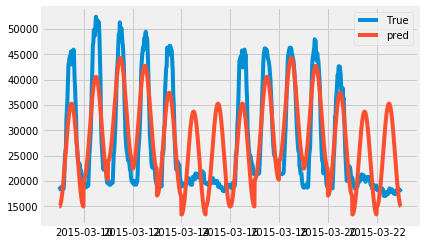

In [153]:
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'pred');
plt.legend();

In [157]:
month['Fractime-week-sin'] = np.sin((2 * np.pi * month['Fractime-week']) / 167.75)
month['Fractime-week-cos'] = np.cos((2 * np.pi * month['Fractime-week']) / 167.75)

In [158]:
two_weeks_index = 14 * 96
train = month.iloc[:two_weeks_index]
test = month.iloc[two_weeks_index:]
train.shape[0] == test.shape[0]

True

In [162]:
lr.fit(train[['time-sin', 'time-cos', 'Fractime-week-cos', 'Fractime-week-sin']], train['Value'])
train_preds = lr.predict(train[['time-sin', 'time-cos', 'Fractime-week-cos', 'Fractime-week-sin']])
test_preds = lr.predict(test[['time-sin', 'time-cos', 'Fractime-week-cos', 'Fractime-week-sin']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 6399.53 	 mape = 20.87
Test : rmse = 5958.94 	 mape = 20.27


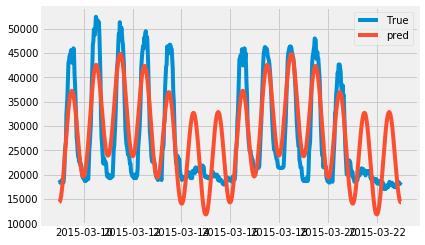

In [163]:
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'pred');
plt.legend();

In [169]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor()
et.fit(train[['time-sin', 'time-cos', 'Fractime-week-cos', 'Fractime-week-sin']], train['Value'])
train_preds = et.predict(train[['time-sin', 'time-cos', 'Fractime-week-cos', 'Fractime-week-sin']])
test_preds = et.predict(test[['time-sin', 'time-cos', 'Fractime-week-cos', 'Fractime-week-sin']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 1319.02 	 mape = 4.16
Test : rmse = 2072.16 	 mape = 6.24


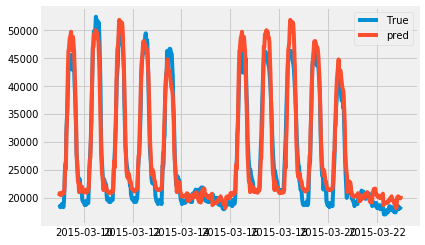

In [170]:
plt.plot(test['Value'], label = 'True')
plt.plot(test.index, test_preds, label = 'pred');
plt.legend();

In [171]:
et.feature_importances_

array([0.00815886, 0.55262036, 0.14637972, 0.29284106])

In [177]:
tree.tree_.node_count

1333

In [174]:
tree = et.estimators_[1]
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file = 'tree.dot', feature_names=['Fractime-week'],
                rounded = True, proportion = True)

In [175]:
!dot -Tpng tree.dot -o tree.png -Gdpi=400

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.138887 to fit


In [176]:
from IPython.display import Image
Image('tree.png')

In [172]:
et = ExtraTreesRegressor()
et.fit(train[['Fractime-week']], train['Value'])
train_preds = et.predict(train[['Fractime-week']])
test_preds = et.predict(test[['Fractime-week']])

_ = metrics(train['Value'], train_preds, 'Train')
_ = metrics(test['Value'], test_preds, 'Test')

Train: rmse = 1318.77 	 mape = 4.15
Test : rmse = 2072.07 	 mape = 6.23


In [ ]:
'time-sin', 'time-cos', 

In [143]:
train.head()

Value  Temperature  off  SiteId  Year  Month  \
Timestamp                                                                  
2015-02-23 00:00:00  20568.482917         20.0  0.0     6.0  2015      2   
2015-02-23 00:15:00  20290.530445          NaN  0.0     6.0  2015      2   
2015-02-23 00:30:00  20012.577973         20.0  0.0     6.0  2015      2   
2015-02-23 00:45:00  20197.879621          NaN  0.0     6.0  2015      2   
2015-02-23 01:00:00  20383.181269         18.5  0.0     6.0  2015      2   

                     Week  Day  Dayofweek  Dayofyear  Hour  Minute  Second  \
Timestamp                                                                    
2015-02-23 00:00:00     9   23          0         54     0       0       0   
2015-02-23 00:15:00     9   23          0         54     0      15       0   
2015-02-23 00:30:00     9   23          0         54     0      30       0   
2015-02-23 00:45:00     9   23          0         54     0      45       0   
2015-02-23 01:00:00     9   23          0         54     1       0       0   

                          Average  
Timestamp                          
2015-02-23 00:00:00  20970.022749  
2015-02-23 00:15:00  20956.577730  
2015-02-23 00:30:00  20943.132711  
2015-02-23 00:45:00  20948.457471  
2015-02-23 01:00:00  20950.587375

In [ ]:
month['time']

## Try a Linear Regression 

In [ ]:
build = data[data['SiteId'] == 6].copy().set_index('Timestamp')
build.index = pd.to_datetime(build.index)
build['Value'].plot()

In [ ]:
build['Value'].describe()

In [ ]:
build.reset_index(inplace = True)

In [ ]:
weekly = build.groupby(['time', 'wday'])['Value'].mean().to_frame().reset_index()
weekly.head()

In [ ]:
sns.lmplot('time', 'Value', weekly, hue = 'wday', fit_reg = False)

In [ ]:
build['time_since'] = (build['Timestamp'] - build.loc[0, 'Timestamp']).dt.total_seconds()

In [ ]:
list(build.columns)

In [ ]:
no_cyc = [x for x in build if ('sin' not in x) and ('cos' not in x)]
no_cyc = no_cyc[4:]
no_cyc

In [ ]:
cyc = no_cyc + [x for x in build if ('sin' in x) or ('cos') in x]
cyc

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(3)

In [ ]:
for (train_indices, valid_indices) in tss.split(build):
    print('N Train indices: ', len(train_indices))
    print('N Valid indices: ', len(valid_indices))

In [ ]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
            ('scaler', MinMaxScaler(feature_range = (0, 1)))])

scaled_data = pipeline.fit_transform(build[no_cyc])

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
imputer = Imputer()

y = imputer.fit_transform(np.array(build['Value']).reshape((-1, 1)))

In [ ]:
scaled_data = np.nan_to_num(scaled_data)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
np.any(~np.isfinite(scaled_data))

In [ ]:
y =

In [ ]:
np.any(~np.isfinite(y))

In [ ]:
et = ExtraTreesRegressor(n_estimators=200)
for (train_indices, valid_indices) in tss.split(build):
    et.fit(scaled_data[train_indices], y[train_indices])
    pred = et.predict(scaled_data[valid_indices])
    print(f'Mean absolute error {round(mean_absolute_error(y[valid_indices], pred), 2)}')

In [ ]:
pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
            ('scaler', MinMaxScaler(feature_range = (0, 1)))])

scaled_data = pipeline.fit_transform(build[cyc])

In [ ]:
et = ExtraTreesRegressor(n_estimators=200)
for (train_indices, valid_indices) in tss.split(build):
    et.fit(scaled_data[train_indices], y[train_indices])
    pred = et.predict(scaled_data[valid_indices])
    print(f'Mean absolute error {round(mean_absolute_error(y[valid_indices], pred), 2)}')

In [ ]:
week = build.groupby('wday')['Value'].mean().to_frame()
week['Value'].plot.bar()

In [ ]:
day = build[build['wday'] < 5].groupby('time')['Value'].mean().to_frame()
day['Value'].plot()

In [ ]:
day.head()

In [ ]:
X = np.array(day.index).reshape((-1, 1))
y = np.array(day.Value)

lr = LinearRegression()
lr.fit(X, y)

In [ ]:
mean_absolute_error(y, lr.predict(X))

In [ ]:
time = np.arange(0, 24, 0.25)
pred = time * lr.coef_[0] + lr.intercept_

plt.plot(pred, label = 'pred')
plt.plot(day['Value'], label = 'true')
plt.legend();

In [ ]:
lr.coef_

In [ ]:
day['time-sin'] = np.sin( (2 * np.pi * day.index) / day.index.max())
day['time-cos'] = np.cos( (2 * np.pi * day.index) / day.index.max())

plt.plot(day['time-sin'], label = 'sin')
plt.plot(day['time-cos'], label = 'cos')
plt.legend();

In [ ]:
lr.fit(np.array(day[['time-sin', 'time-cos']]), y)

In [ ]:
mean_absolute_error(y, lr.predict(np.array(day[['time-sin', 'time-cos']])))

In [ ]:
time = np.arange(0, 24, 0.25)
pred = day['time-sin'] * lr.coef_[0] + day['time-cos'] * lr.coef_[1] + lr.intercept_

plt.plot(pred, label = 'pred')
plt.plot(day['Value'], label = 'true')
plt.legend();

In [ ]:
day.reset_index(inplace = True)

lr.fit(np.array(day[['time', 'time-sin', 'time-cos']]), y)
mean_absolute_error(y, lr.predict(np.array(day[['time', 'time-sin', 'time-cos']])))

In [ ]:
time = np.arange(0, 24, 0.25)
pred = day['time'] * lr.coef_[0] + day['time-sin'] * lr.coef_[1] + day['time-cos'] * lr.coef_[2] + lr.intercept_

plt.plot(pred, label = 'pred')
plt.plot(day['Value'], label = 'true')
plt.legend();

In [ ]:
week

In [ ]:
def extract_dateinfo(df, date_col, drop=True, time=False, start_ref = pd.datetime(1900, 1, 1)):
    """
    Extract Date Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[fldname]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    
    targ_pre = re.sub('[Dd]ate', '', fldname)
    targ_pre = re.sub('[Tt]ime', '', targ_pre)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    # If time is specified, add extra columns
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if time:
        # Add fractional time of day
        df[targ_pre + 'FractimeDay'] = (df[targ_pre + 'Hour'] / 24) + (df[targ_pre + 'Minute'] / 60 / 24) + (df[targ_pre + 'Second'] / 60 / 60 / 24)
        
        # Add fractional time of week
        df[targ_pre + 'FractimeWeek'] = ((df[targ_pre + 'Dayofweek'] * 24) + (df[targ_pre + 'FractimeDay'] * 24)) / (7 * 24)
    
    # Add seconds since start of reference
    df[targ_pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(fldname, axis=1)
        
    return df